# Ultracool Machine Learning Code Tutorial Notebook

Authored by Camille. If there is anything missing or could be elaborated on, raise an issue or message me directly!

In [1]:
import numpy as np
from sklearn.datasets import make_classification

# Any custom functions we write will be imported from their module in the spectral_binaries package.
from spectral_binaries.train import run_RF
from spectral_binaries.visualization import (
    plot_feature_importance,
    plot_confusion_matrix,
    plot_roc,
    plot_prc,
    plot_calibration
)

For our example, let's pretend this dataset from `sklearn`'s `make_classification` function is our dataset of single and binary templates.

In [2]:
X, y = make_classification(n_samples=10000, n_features=20, n_redundant=0, n_clusters_per_class=1, random_state=0)

# Running the RF Pipeline

Right now, the whole ML pipeline can be run by calling the wrapper function `run_RF`, imported above, with necessary arguments. The arguments you pass in will configure the training process, whether that includes hyperparameter train/test splitting, feature selection, grid search, or calibration (explained later in the notebook). This function assumes your input features `X` and labels `y` are preprocessed and prepared for modeling. The function returns a dictionary containing:
- `model`: Fitted model (if calibration used, RF is stored in the `estimator` key and its calibration wrapper is stored in `model`).
- `estimator`: Fitted RF estimator, if calibration used.
- `X_test`: Testing features for plotting. Transformed if feature selection used.
- `y_test`: Ground truth test labels for plotting.
- `y_pred`: Test predictions for plotting.
- Test metrics including precision, recall, f-1, as separate keys.

In [3]:
print(run_RF.__doc__)

Run the ML pipeline.

    Split the dataset, run RF feature extraction, training, calibration, and
    prediction.

    Parameters
    ----------
    X : Union[np.ndarray, pd.DataFrame]
        Input features.
    y : Iterable[int]
        Ground truth labels.
    grid_search : bool
        Whether to run grid search, default True..
    cv : int
        Number of splits for CV in grid search. If grid_search is False, use
        CV in calibration. If no calibration method specified, don't run
        calibration and ignore CV, default 5.
    test_size : float
        Ratio of test set size to whole dataset, default 0.2.
    random_state : int
        Random seed, default 0.
    n_jobs : n_jobs
        Number of CPUs for RF model, default all.
    feature_extraction_method : str, optional
        Method for the feature extraction. Either chi2, mutual_info, f-test, or
        corr.
    calibration_method : str, optional
        Method for calibration, either Platt (sigmoid) scaling or is

### Examples

Run baseline RF with no feature extraction, grid search, or calibration.
```
run_RF(X, y)
```

Run a custom RF with no feature extraction, grid search, or calibration.
```
run_RF(X, y, max_depth=5)
```

Run RF with grid search (5-CV), no calibration or feature extraction.

```
run_RF(X, y, grid_search=True)
```

Run RF with recursive feature selection. `estimator` and `num_features` are specific to the recursive feature extractor.

```
run_RF(X, y, feature_extraction_method="recursive", estimator=RandomForestClassifier(), num_features=12)
```

Run RF with recursive feature selection, grid search with 10-CV, and calibration.

```
run_RF(
    X,
    y,
    grid_search=True,
    cv=10,
    feature_extraction_method="sequential",
    calibration_method="isotonic",
    estimator=RandomForestClassifier(),
    num_features=12,
)
```

In [5]:
# Examples for plotting demonstration
results = run_RF(X, y, grid_search=True)
results_calib = run_RF(X, y, grid_search=True, calibration_method="isotonic")

Running grid search on training set...
Best parameters found:  {'min_samples_split': 2}
Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       981
           1       0.94      0.91      0.93      1019

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

Running grid search on training set...
Best parameters found:  {'min_samples_split': 2}

Brier score loss before calibration: 0.0594195
Brier score loss after calibration: 0.05617185995384551 

Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       981
           1       0.94      0.91      0.93      1019

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



**IMPORTANT**: DO NOT run cross-validation again for evaluating the final model you get from the function. It was already run for model selection, and running it again on a final model can produce and overestimation of the true performance. `run_RF` already addresses this.

## Feature Selection

Feature selection is the process of selecting a subset of features, based on different criteria, to be used for modeling. This is built into `run_RF` and can easily be configured with the function's arguments. It is implemented as a `FeatureSelectionWrapper` class in `spectral_binaries/feature_selection.py`. This is necessary for several reasons:
- Reducing overfitting
- Improving accuracy because the model will learn from only informative features
- Reducing computational complexity
- Increasing interpretability

Using FE might not always work but is good step for experimentation, anyway. There are two main types of feature selection that are currently implemented:
- **Filter-based:** Feature selection based on statistical properties (chi-squared, correlation, mutual information, or ANOVA F-score). **NOTE:** These methods do not support negative values, and passing negative values into these extractors will cause an error. Normalize the data to the [0, 1] range before using a filter-based FE method.
- **Wrapper-based:** Recursive feature elimination, and sequential feature selection. These will take significantly longer to run, but could lead to better performance than the former method.

Refer to the documentation in `FeatureSelectionWrapper` for the pros and cons of both types.

Example usage in `run_RF`:
```
run_RF(X, y, feature_selection_method="sequential", estimator=RandomForestClassifier())
```

# Plots

All the plotting functionality we need is implemented in `visualization.py`, and require the model, testing data, and predictions from the dictionary returned by `run_RF`.

## Confusion Matrix

In [6]:
print(plot_confusion_matrix.__doc__)

Plot a confusion matrix from binary arrays y_true and y_pred.

    Parameters
    ----------
    y_true : Union[pd.Series, np.ndarray]
        Ground truth labels.
    y_pred : np.ndarray
        Predicted labels.
    classes : List
        Class names for tick labels, default ["Single", "Binary"].
    cmap : str
        Color map name, default "Blues".
    normalize : str, optional
        Normalization method, default "true".
    file_name : str, optional
        If specified, save as file with name, default not specified.
    title : str, optional
        If specified, set figure title.

    Examples
    --------
    >>> _y_true = np.array([1, 0, 1, 0, 0, 1, 1, 0, 1, 0])
    >>> _y_pred = np.array()[1, 0, 1, 1, 0, 1, 0, 0, 1, 0])
    >>> plot_confusion_matrix(_y_true, _y_pred, file_name="test.pdf")

    Returns
    -------
    None
    


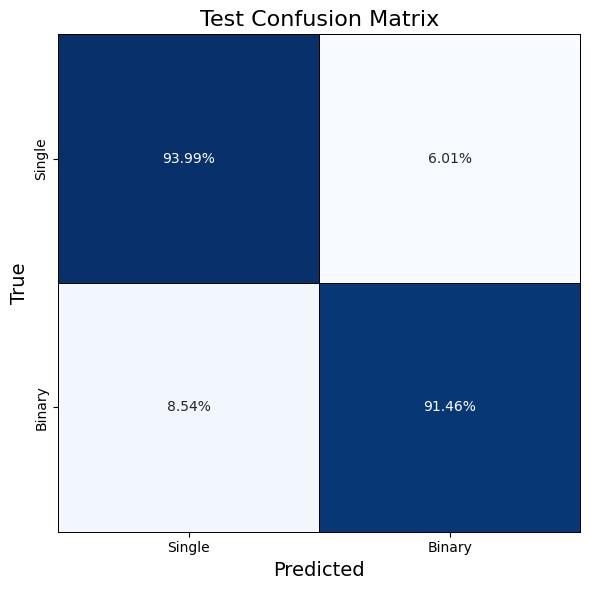

In [7]:
plot_confusion_matrix(results["y_test"], results["y_pred"], title="Test Confusion Matrix")

## Feature Importance

When plotting feature importance, if you did not calibrate the model, you can pass in as the model for `plot_feature_importance` `results["model"]`. If you calibrated the model, instead pass in `results["estimator"]`, which extracts the RF estimator from the calibration model.

In [8]:
print(plot_feature_importance.__doc__)

Plot the feature importance of a fit RF model.

    Parameters
    ----------
    model : RandomForestClassifier
        Model trained on templates.
    feature_names : Iterable[str]
        Names of the features for the plot.
    n : int
        Top n most important features to plot.
    file_name : str, optional
        File name for saving the feature importance plot.
    error_bars : bool
        Whether to plot error bars in the feature importance plot.

    Returns
    -------
    pd.DataFrame
        Feature importance DataFrame.
    


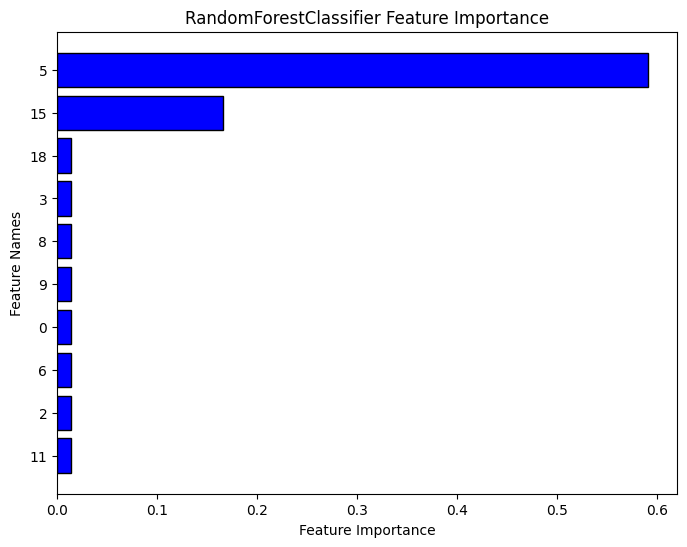

,feature_names,feature_importance,std
11,11,0.590394,0.056783
2,2,0.166349,0.029528
6,6,0.014350,0.003916
0,0,0.014273,0.004224
9,9,0.014215,0.004508
8,8,0.013831,0.005034
3,3,0.013803,0.005075
18,18,0.013756,0.004557
15,15,0.013722,0.004137
5,5,0.013626,0.004156


In [9]:
# Uncalibrated
plot_feature_importance(results["model"], np.arange(X.shape[1]))

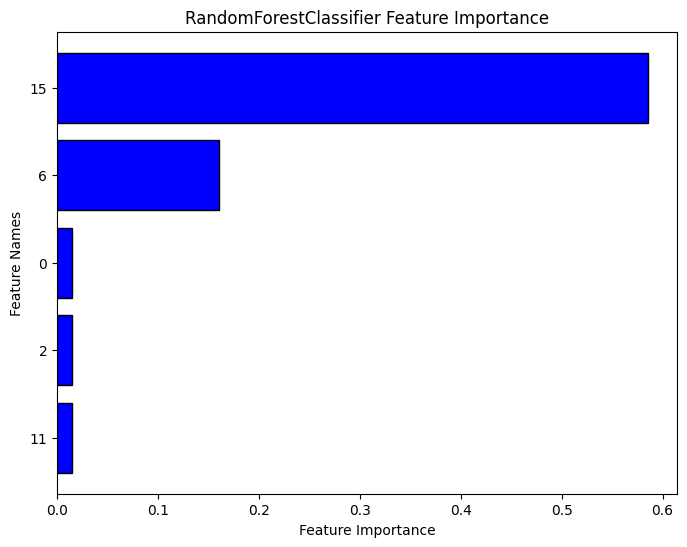

,feature_names,feature_importance,std
11,11,0.585077,0.059597
2,2,0.160907,0.027822
0,0,0.014958,0.004534
6,6,0.014856,0.004326
15,15,0.014768,0.005388


In [10]:
# Calibrated, with n = 5 as an example
plot_feature_importance(results_calib["estimator"], np.arange(X.shape[1]), n=5)

## Other Visualizations

You can produce these plots as well after fitting the RF model and making predictions, to get additional insight on model performance.

### ROC Curve

The **Receiver Operating Characteristic (ROC)** is a way of evaluating how well a model can classify positive (spectral binary) and negative (singles). The true positive rate is positive rate is plotted on the y-axis, while the false positive rate is plotted on the x-axis. To create an ROC curve, the model is first trained on a labeled dataset, and the threshold for positive predictions is varied to generate a set of pairs (FPR, TPR) at different threshold values.

An ideal ROC curve is one that hugs the top-left corner (AUC = 1.00) of the graph, meaning the model has a high true positive rate and a low false positive rate at all threshold values.  A random classifier, on the other hand, would produce a diagonal line from the bottom-left to the top-right of the graph (AUC = 0.50), indicating that it performs no better than chance.

In [11]:
print(plot_roc.__doc__)

Plot an ROC Curve of a fitted model on the testing data.

    Parameters
    ----------
    model : RandomForestClassifier
        Model fitted on templates.
    X_test : Union[np.ndarray, pd.DataFrame]
        DataFrame or 2D array of testing features.
    y_test : Iterable[int]
        Test ground truth labels.
    file_name : str
        File name for saving the ROC plot.

    Returns
    -------
    None
    


<Figure size 800x600 with 0 Axes>

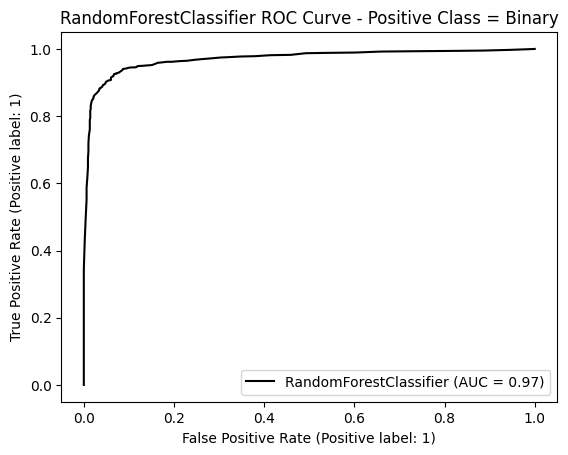

In [12]:
plot_roc(results["model"], results["X_test"], results["y_test"])

### Precision-Recall Curve

As you may know, **precision** is a measure of how accurate the model is when it predicts a positive result (i.e., binary system). If the model identifies a system as binary, precision measures how likely it is that the system is actually binary. **Recall** is a measure of how well the model can identify all the positive examples in the data. For example, if there are 100 spectral binaries in our dataset and the model only identifies 80 of them, our recall will be 80%.

The **precision-recall curve** shows how precision and recall change as the threshold for a positive prediction is adjusted. The threshold determines how confident the model needs to be to predict a spectral binary. If the threshold is set high, the model will only predict a spectral binary when it is very certain, resulting in a high precision but low recall. If the threshold is set low, the model will predict more spectral binaries, resulting in a higher recall but lower precision.

In [13]:
print(plot_prc.__doc__)

Plot a Precision-Recall Curve (PRC) of a fitted model on the test data.

    Parameters
    ----------
    model : RandomForestClassifier
        Model fitted on templates.
    X_test : Union[np.ndarray, pd.DataFrame]
        DataFrame of 2D array of testing features.
    y_test : Iterable[int]
        Test ground truth labels.
    file_name : str
        File name for saving the PRC plot.

    Returns
    -------
    None
    


<Figure size 800x600 with 0 Axes>

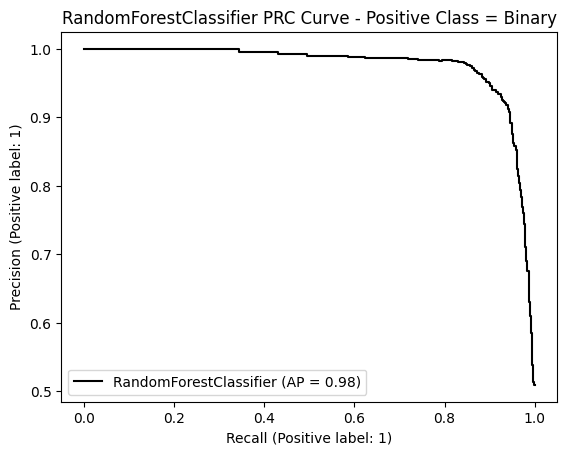

In [14]:
plot_prc(results["model"], results["X_test"], results["y_test"])

### Calibration Plots
Calibration plots are a valuable tool for evaluating the performance of binary classification models, especially when predicting probabilities. In a binary classification problem, the model must predict whether a given instance belongs to one of two possible classes. However, in addition to simply making a prediction for each instance, many classification algorithms also provide a probability estimate of how likely the instance is to belong to each class.

Calibration plots help us evaluate whether the predicted probabilities from a binary classification model are accurate. Specifically, a calibration plot compares the *predicted probabilities to the actual observed frequencies of each class*, across a range of predicted probabilities. In a well-calibrated model, the predicted probabilities should be close to the observed frequencies, which indicates that the model's probability estimates are reliable.

*Why should we care about accurate probabilities?* The model's predicted probabilities provide insight into the model's overall performance and reliability of its predictions. For example, let's say a binary classification model is being used to predict whether a patient has a certain medical condition. The model produces a probability estimate for each patient, indicating the likelihood of having the condition. If the model's predicted probabilities are well-calibrated, a high probability estimate indicates that the patient is more likely to have the condition, and a low probability estimate indicates that the patient is less likely to have it.

On the other hand, if the model's predicted probabilities are not well-calibrated, a high probability estimate may not accurately reflect the truth likelihood of the patient having the condition, leading to incorrect decisions are actions. The model may produce high probability estimates for patients who do not have the condition, leading to unnecessary testing or treatment.

To create a calibration plot, we first divide the range of predicted probabilities into several "bins" or intervals. The actual observed frequencies of each class are then calculated for each bin. Then, we calculate and plot the average predicted probability for each bin A well-calibrated model will produce a calibration plot where the *points fall close to the diagonal line*, indicating that the predicted probabilities are close to the observed frequencies.

*Why is all of this useful?* First, it allows us to assess the reliability of the model's probability estimates. Second, it can help us identify and correct systematic biases in the model's predictions. Finally, we can use it to compare the calibration of different models, helping us select the best model for our task.

In [15]:
print(plot_calibration.__doc__)

Plot a calibration plot of the fitted model on the test data.

    Parameters
    ----------
    model : RandomForestClassifier
        Model fitted on templates.
    X_test : Union[np.ndarray, pd.DataFrame]
        DataFrame or 2D array of testing features.
    y_test: Iterable[int]
        Test ground truth labels.
    num_bins : int
        Number of bins for the calibration plot. 6 by default.
    strategy: str
        Binning strategy, either uniform or quantile. Uniform by default.
    file_name : str, optional
        File name for saving the calibration plot.

    Returns
    -------
    None
    


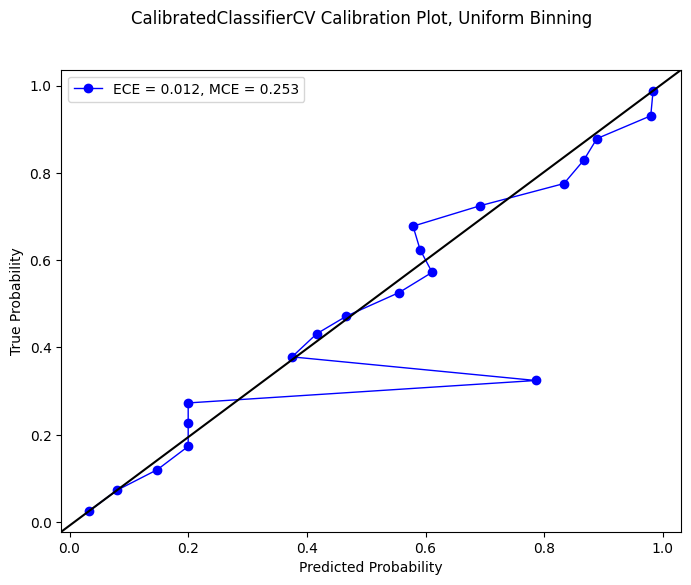

In [16]:
plot_calibration(results_calib["model"], results_calib["X_test"], results_calib["y_test"], 20)

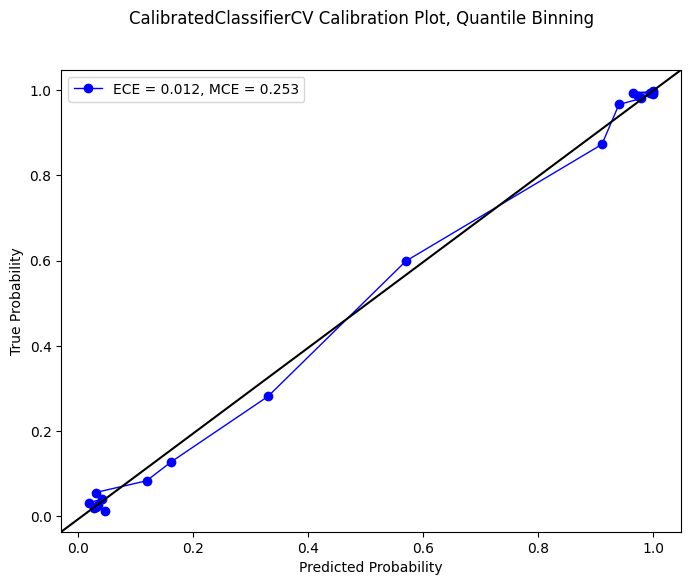

In [17]:
plot_calibration(results_calib["model"], results_calib["X_test"], results_calib["y_test"], 20, strategy="quantile")

As we can see, the model appears better calibrated when we adjust for sample size, using the `quantile` binning strategy.

#### Choosing the Number of Bins

Choosing the appropriate number of bins requires a trade-off between the granularity of the plot and the number of examples in each bin. There are some guidelines and heuristics that can be used as a starting point for choosing the number of bins.
1. **Use a minimum of 10-15 bins.** Using fewer can result in a too coarse or smooth calibration plot.
2. **Use a maximum of 20-30 bins.** Using more can result in a too granular calibration plot that may not be visually interpretable, and may lead to overfitting or instability of the calibration measurements due to small sample sizes in each bin.
3. **Use a uniform or quantile-based binning.** Uniform binning involves diving the range of predicted probabilities into equally spaced intervals, while quantile-based binning involves dividing the range of predicted probabilities into intervals that contain roughly the same number of examples. Quantile-based binning can be more robust to outliers and skewed distributions, but may result in unevenly sized bins. You can pass in either a `uniform` or `quantile` strategy into `plot_calibration`. `uniform` is used by default.
4. **Consider the sample size in each bin.** Ideally, each bin should contain a sufficient number of examples to ensure reliable calibration measurements. A commonly used heuristic is to require at least 5-10 examples in each bin, although this may vary depending on the size of the dataset and the variability of predicted probabilities.
5. **Experiment with different binning schemes.** It is a generally good idea to experiment with different binning schemes and evaluate the resulting calibration plots using metrics such as Expected Calibration Error (ECE) or the Maximum Calibration Error (MCE). This can help identify the optimal number and type of bins for a given dataset model.

#### ECE and MCE

- The **Expected Calibration Error (ECE)** is a measure of the difference between the predicted probabilities and the true probabilities of the positive class, averaged over all bins of predicted probabilities. It is computed as the weighted average of the absolute difference between the average predicted probability and the true frequency of the positive class and each been, where the weights are the proportion of data points in each bin.
- The **Maximum Calibration Error (MCE)** is simply the maximum absolute difference between the predicted probabilities and the true probabilities in any bin.

#### Calibrating a Model

Here are some common methods to calibrate the model.

1. **Platt scaling:** Fit a logistic regression model to the predicted outputs of the original model on a validation set, where the target variable is the true binary class label. The logistic regression model can then be used to map the original outputs to calibrated probabilities.
2. **Isotonic regression:** Fit a non-parametric model to the predicted outputs of the original model on a validation set. The non-parametric model fits a monotonically increasing function to the outputs, such that the mapping from predicted outputs to calibrated probabilities is also monotonically increasing.
3. **Temperature scaling:** Scale the logits (unnormalized log probabilities) of the original model by a learnable scalar parameter called the temperature, which controls the confidence of the model's predictions. The temperature can be learned on a validation set using maximum likelihood estimation, by minimizing the negative log likelihood of the true binary class labels.

You can calibrate the model by passing in either `sigmoid` (Platt) or `isotonic` to the `calibration_method` argument of `run_RF`. This is optional!